In [ ]:
!pip install kaggle --upgrade

In [ ]:
from google.colab import files
files.upload()
# 파일 선택 버튼 클릭 후 kaggle.json 파일 업로드

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jeongjupark","key":"62b69e96534187da9dd3b0dc8ced0a6f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/Colab Notebooks/hnm'

/content/drive/MyDrive/Colab Notebooks/hnm


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
articles = pd.read_csv(f"articles.csv", encoding="utf-8", dtype={'article_id': str})
customers = pd.read_csv(f"customers.csv", encoding="utf-8")
transactions = pd.read_csv(f"transactions_train.csv", encoding="utf-8", dtype={'article_id': str}, parse_dates=['t_dat'])

In [ ]:
# explore the data shape (rows, columns) and the name of its coloumns
print("articles shape:",articles.shape)
print("articles columns name:", articles.columns)

print("customers shape:",customers.shape)
print("customers columns name:", list(customers.columns))

print("transactions shape:",transactions.shape)
print("transactions name:", list(transactions.columns))

articles shape: (105542, 25)
articles columns name: Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')
customers shape: (1371980, 7)
customers columns name: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code']
transactions shape: (31788324, 5)
transactions name: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


# Articles

In [7]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [15]:
# id is unique
articles.shape[0] - articles['article_id'].nunique()

0

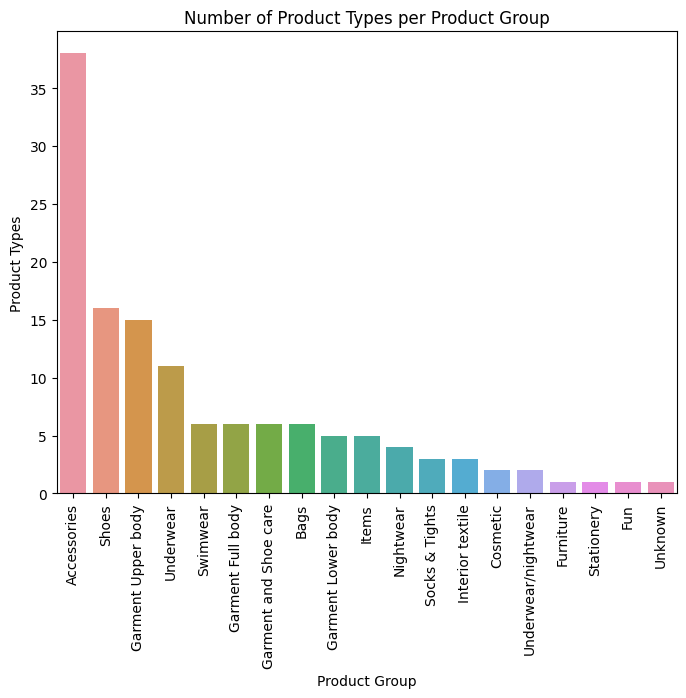

In [ ]:
# Number of Product Types per Product Group
prod_grps = articles.groupby(["product_group_name"])["product_type_name"].nunique()
df = pd.DataFrame({"Product Group": prod_grps.index, "Product Types": prod_grps.values})
df = df.sort_values(["Product Types"], ascending=False)
plt.figure(figsize=(8, 6))
plt.title("Number of Product Types per Product Group")
sns.set_color_codes("pastel")
s = sns.barplot(x="Product Group", y="Product Types", data=df)
locs, labels = plt.xticks()
plt.xticks(rotation=90)
plt.show()


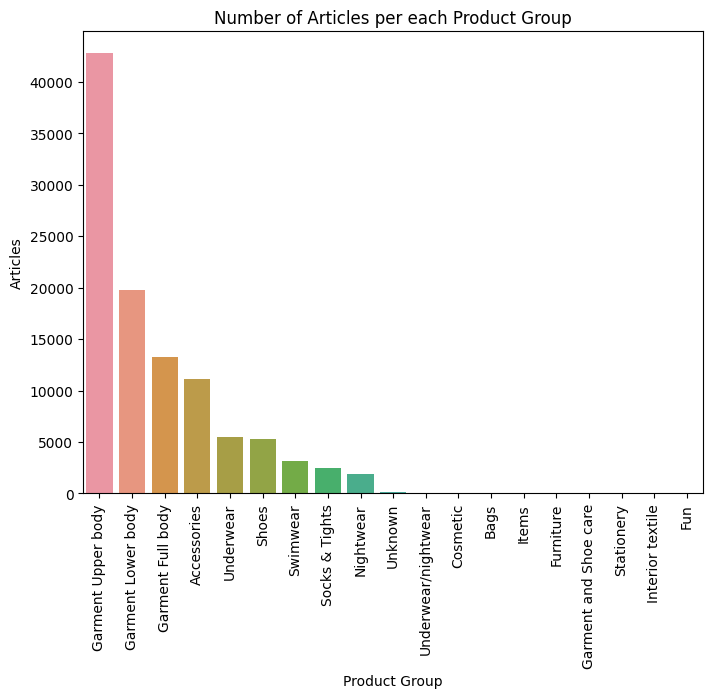

In [11]:
temp = articles.groupby(["product_group_name"])["article_id"].nunique()
df = pd.DataFrame({'Product Group': temp.index,
                   'Articles': temp.values
                  })
df = df.sort_values(['Articles'], ascending=False)
plt.figure(figsize = (8,6))
plt.title('Number of Articles per each Product Group')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Product Group', y="Articles", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

# Customers

In [8]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [13]:
# id is unique
customers.shape[0] - customers['customer_id'].nunique()

0

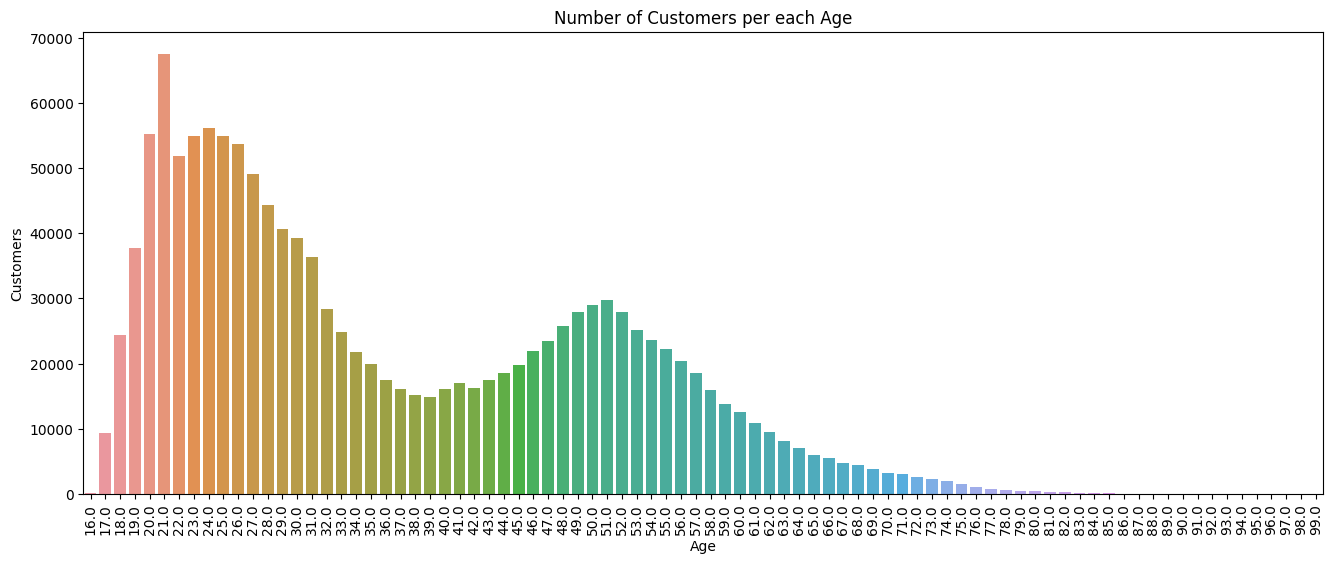

In [12]:
temp = customers.groupby(["age"])["customer_id"].count()
df = pd.DataFrame({'Age': temp.index,
                   'Customers': temp.values
                  })
df = df.sort_values(['Age'], ascending=False)
plt.figure(figsize = (16,6))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'Age', y="Customers", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

# Transactions

In [9]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2
